In [1]:
# 모듈 호출
import os
import glob
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D, AvgPool2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# # 드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# cd /content/drive/MyDrive/안봐도보이조_project

# 모델링

- 데이터셋 정의

In [4]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './train_10',
    batch_size=50,      
    class_mode='categorical', 
    target_size=(64, 64)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './valid_10',
    batch_size=20,      
    class_mode='categorical', 
    target_size=(64, 64))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './test_10',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(64, 64),shuffle=False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [5]:
print(train_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


In [6]:
print(valid_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


In [7]:
print(test_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


# LeNet-5
- Yann LeCun (얀 르쿤)의 "Gradient-based learning applied to document recognition" 논문에서 손글씨 숫자 인식하는데 문제를 해결하기 위해 사용된 모델
- 3차원인 MNIST 데이터 (28,28,1)를 input으로 함

In [8]:
# LeNet 모델링
model = Sequential()
model.add(Conv2D(6,5,strides=1,activation='relu',input_shape=(64,64,3),padding='same'))
model.add(AvgPool2D(2,strides=2))
model.add(Conv2D(16,5,strides=1,activation='relu'))
model.add(AvgPool2D(2,strides=2))
model.add(Conv2D(120,5,strides=1,activation='relu'))
model.add(Flatten())
model.add(Dense(84,activation='tanh'))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [9]:
#early_stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 32, 32, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 120)       48120     
                                                                 
 flatten (Flatten)           (None, 12000)             0

## 모델 훈련하기
- steps_per_epoch : max (train의 총 이미지갯수//train의 batch_size)
- validation_steps : max (valid의 총 이미지갯수//valid의 batch_size)
- epochs = 1000 : 1000회 반복
- callbacks : EarlyStopping(monitor='val_loss', patience=10) 
- 10회동안 성능개선이 없을 시 학습 종료

In [11]:
history = model.fit(train_generator,
                    steps_per_epoch=10529//50, # max : 총 이미지 수 / batch_size
                    epochs=1000, 
                    validation_data=valid_generator, 
                    validation_steps=1000//20,
                    callbacks=[early_stopping_callback]
                    ) 

Epoch 1/1000
210/210 [==============================] - 18s 86ms/step - loss: 1.0728 - accuracy: 0.6017 - val_loss: 0.4342 - val_accuracy: 0.8270
Epoch 2/1000
210/210 [==============================] - 18s 86ms/step - loss: 0.3704 - accuracy: 0.8562 - val_loss: 0.2761 - val_accuracy: 0.8910
Epoch 3/1000
210/210 [==============================] - 18s 87ms/step - loss: 0.2643 - accuracy: 0.8949 - val_loss: 0.2085 - val_accuracy: 0.9250
Epoch 4/1000
210/210 [==============================] - 18s 87ms/step - loss: 0.2296 - accuracy: 0.9084 - val_loss: 0.3053 - val_accuracy: 0.8820
Epoch 5/1000
210/210 [==============================] - 19s 88ms/step - loss: 0.2640 - accuracy: 0.8883 - val_loss: 0.2812 - val_accuracy: 0.9050
Epoch 6/1000
210/210 [==============================] - 18s 87ms/step - loss: 0.2026 - accuracy: 0.9169 - val_loss: 0.1245 - val_accuracy: 0.9540
Epoch 7/1000
210/210 [==============================] - 18s 88ms/step - loss: 0.1827 - accuracy: 0.9245 - val_loss: 0.1163 -

- 모델 성능 평가하기

In [12]:
model.evaluate(test_generator)

50/50 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9940


[0.019177353009581566, 0.9940000176429749]

- 모델 성능 시각화

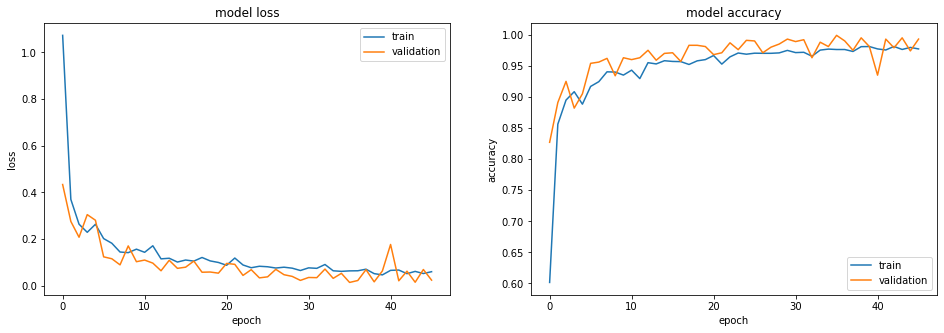

In [13]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

- 모델 저장

In [14]:
model.save('./model/LeNet05_local_04.h5')

- 모델 호출

In [15]:
from tensorflow.keras.models import load_model
model = load_model('./model/LeNet05_local_04.h5')

- 모델을 이용하여 직접 촬영한 사진 분류해 보기

In [16]:
test_img = cv2.imread('./123.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(64,64))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[1.7212223e-08, 9.9937975e-01, 1.2681135e-09, 6.2925452e-09,
        1.5286607e-06, 3.0240117e-05, 9.0586729e-09, 5.5140583e-07,
        5.8232539e-04, 5.5210226e-06]], dtype=float32)

In [17]:
pred_result = model.predict(test_img).argmax()
pred_result

1

In [19]:
train_generator.class_indices

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [20]:
result_dict = dict(map(reversed, train_generator.class_indices.items()))
result_dict

{0: '갈아만든배',
 1: '레쓰비',
 2: '마운틴듀',
 3: '밀키스',
 4: '스프라이트',
 5: '칠성사이다',
 6: '코카콜라',
 7: '트로피카나망고',
 8: '펩시콜라',
 9: '환타오렌지'}

In [21]:
result_dict[pred_result]

'레쓰비'

In [22]:
categories = list(result_dict.values())
# 딕셔너리의 value 값을 리스트로 받기
categories

['갈아만든배',
 '레쓰비',
 '마운틴듀',
 '밀키스',
 '스프라이트',
 '칠성사이다',
 '코카콜라',
 '트로피카나망고',
 '펩시콜라',
 '환타오렌지']

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

np.set_printoptions(precision=2)

Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1)  # Returns maximum indices in each row

class_names = categories

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))



print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

-- Confusion Matrix --
[[49  0  1  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 49  1  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  1  0  0  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0  0  0 50]]
-- Classification Report --
              precision    recall  f1-score   support

       갈아만든배       1.00      0.98      0.99        50
         레쓰비       0.98      1.00      0.99        50
        마운틴듀       0.98      1.00      0.99        50
         밀키스       1.00      1.00      1.00        50
       스프라이트       1.00      0.98      0.99        50
       칠성사이다       0.98      1.00      0.99        50
        코카콜라       1.00      1.00      1.00        50
     트로피카나망고       1.00      1.00      1.00        50
        펩시콜라       1.00      0.98      0.99        50
       환타오렌지       1.00      1.00      1.00        50

    accuracy          

<AxesSubplot:>

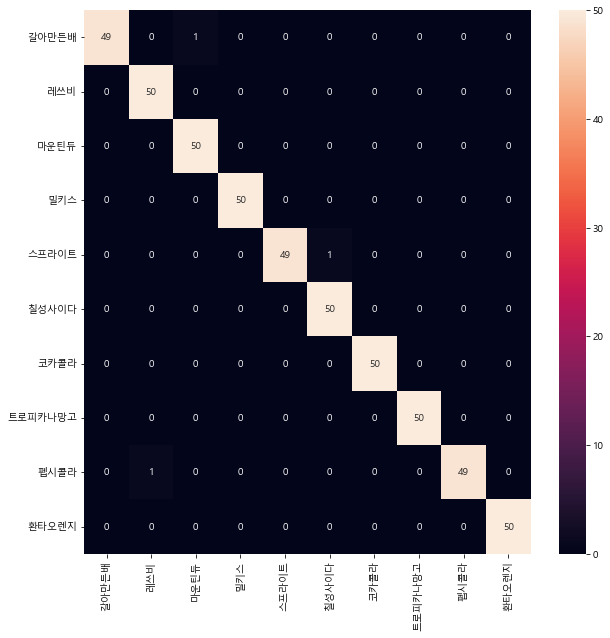

In [25]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d',
            xticklabels=categories,
            yticklabels=categories)
# 로컬에서 주피터로 진행해서 히트맵뽑기